In [2]:
library(reshape2)
library(magrittr)
library(dplyr)
library(ggplot2)
library(viridis)

DATA.DIR = '../data/'


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: viridisLite


### About the Data
In 2018 Boulder PD released a (cleaned and processed) dataset containing information on all *discretionary* stops made by Boulder police in 2018. Discretionary stops make up only a fraction of Boulder police activity, with the vast majority of police interactions being *non-discretionary*, eg. where an officer was dispatched based on a 911 call. Approximately 66,400 police interactions are non-discretionary (per an in person introduction to the data organized by the City of Boulder on May 6, 2019). 

The original data is broken into two files: `police_stop_data_main_2018.csv` and `police_stop_data_results_2018.csv`. The first dataset contains a row for every individual discretionary stop made by Boulder PD. Let's see what columns the data includes:

In [3]:
'police_stop_data_main_2018.csv' %>% paste0(DATA.DIR,.) %>% read.csv %>% names %>% print

 [1] "stopdate"      "stoptime"      "streetnbr"     "streetdir"    
 [5] "street"        "Min"           "sex"           "race"         
 [9] "ethnic"        "Year.of.birth" "enfaction"     "rpmainid"     


We see columns for stop date, time, and duration (in minutes). We see plots for the race, ethnicity, and sex of the stopped individual **as percieved by the reporting officer**. We also have columns `enfaction`, which indicates if the stopped individual was a resident of Boulder or not, and an `rpmainid`, which links each row to data in the second dataset.

The structure of `police_stop_data_results_2018.csv` is slightly more complex. This file contains information on the stops listed in the `main` dataset, as well as any potential outcomes of each. Let's see what columns it has:

In [4]:
'police_stop_data_results_2018.csv' %>% paste0(DATA.DIR,.) %>% read.csv %>% names %>% print

[1] "appkey"   "appid"    "itemcode" "itemdesc" "addtime" 


The `appid` column is used to link rows in `results` to rows in `main` (through the `rpmainid` column in `main`). A big difference here is that each value of `rpmainid` appears in only one row in `main`, whereas a single `appid` might be listed in multiple rows in `results`. The `appkey` column contains one of seven different values, 'RPT1' through 'RPT7', which indicate what kind of information is contained in the row:

| Appkey | Data              |
|--------|-------------------|
| RPT1   | Stop type         |
| RPT2   | Stop reason       |
| RPT3   | Search conducted  |
| RPT4   |  Search authority |
| RPT5   |  Contraband found |
| RPT6   | Result of stop    |
| RPT7   |  Charge issued    |


In addition, each pair of `appid` and `appkey` might be listed in multiple rows, eg. if there's more than one result of the stop. This is not a very convenient data stucture. It would be far better if all of the information was present in a single dataset, and if each row corresponded to exactly one stop (ie. if the data was "tidy"). Fortunately my friend Sam has gone ahead and tidied the data. Let's see the results...

In [6]:
dat = read.csv(paste0(DATA.DIR,'tidy.csv')) %>% set_colnames(tolower(names(.)))
data %<>% mutate(raceethn=ifelse(ethnic=='H',race%>%paste0('H'), race%>%as.character))
dat %>% names %>% print

 [1] "stopdate"                            "stoptime"                           
 [3] "streetnbr"                           "streetdir"                          
 [5] "street"                              "min"                                
 [7] "sex"                                 "race"                               
 [9] "ethnic"                              "year.of.birth"                      
[11] "enfaction"                           "rpmainid"                           
[13] "raceethn"                            "rpt1.pedestrian"                    
[15] "rpt1.vehicle"                        "rpt2.disturbance"                   
[17] "rpt2.equipment.violation"            "rpt2.municipal.violation"           
[19] "rpt2.noise.violation"                "rpt2.right.of.way.violation"        
[21] "rpt2.speeding"                       "rpt2.state.violation"               
[23] "rpt2.suspicious"                     "rpt2.traffic.parking.violation"     
[25] "rpt2.traffic.reckless.

In [10]:
tellme = function(x){
    read.csv(paste0(DATA.DIR,'/police_stop_data_dictionary.csv')) %>%
        filter(Column.Name==x) %>%
        select(Description) %>%
        return
}

app.key.list = function(n){
    key = paste0('rpt',as.character(n))
    data %>% select(starts_with(key)) %>% names %>% return
}

tellme('appkey')


Description
"Type of Police activity as part of the stop. RPT1=Type of Stop, RPT2=Stop Reason, RPT3=Search Conducted, RPT4=Search Authority, RPT5=Contraband Found, RPT6=Result of Stop."


### A Bayesian Idiom 
#### Probability Notation
$\text{Pr}[Y=x]$ is "the probability that random variable Y takes value x"
$\text{Pr}[Y]$ is an abbreviation of the above, where $x$ is implied to be variable ie. the probability density function
$\text{Pr}[Y=x|A=b]$ is "the probabilty that random variable $Y=x$ given that $A=b$"

#### Binomial Random Variable
One of the first problems to be addressed using the Bayesian methodology was that of estimating the "probability" parameter of a binomial random variable. Say that a random variable $X$ takes values in $\{0,1\}$, with $\text{Pr}[X=1] = \pi$. Say that we observe $n$ such draws of $X$, which we will denote $X_1=X_1,...,X_n=x_n$. The probability of this sequence of observations is:
$$
\text{Pr}[X_1=x_1,...,X_n=x_n|\pi=p] = S_n^p (n-s_n)^{1-p}
$$
Where $s_n = \sum_i^n x_i$. Furthermore (per the principal of indifference) we can place a uniform prior over $p$. Per Bayes theorem, we can therefore say the following:
$$
\text{Pr}[\pi=p|X_1=x_1,...,X_n=x_n] \propto s_n^p (n-s_n)^{1-p}
$$
One can quickly see that this posterior is simply a Beta distribution with parameters $\alpha=1+s_n$ and $\beta=1+(n-s_n)$. Per standard results about the Beta distribution, the posterior expected value of $\pi$ is then $\frac{1+s_n}{2+n}$ and the posterior variance is $\frac{(1+s_n)(1+n - s_n)}{(2+n)^2(3+n)}$. These give us some handy formulae to perform inference over $p$, which we'll encode using some helper functions

In [ ]:
# posterior distribution given binomial likelihood and beta prior                              
binom.posterior = function(p, outcome_vec, pr.alpha=1, pr.beta=1){
    p %>% dbeta(pr.alpha + sum(outcome_vec), pr.beta + length(outcome_vec) - sum(outcome_vec)) %>%
        return
}

binom.posterior.exp.var = function(outcome_vec,pr.alpha=1,pr.beta=0){
    a = pr.alpha + sum(outcome_vec)
    b = pr.beta + length(outcome_vec) - sum(outcome_vec)
    mean = a/(a+b)
    var = (a*b)/((a+b+1)*(a+b)^2)
    return(list('mean'=mean,'var'=var))
}

### Who's deemed suspicious?
The data includes some entries for appkey "RPT2: Stop reason", and some the listed stop reasons are "suspicious. For anyone who's even vaguely paying attention this will probably set off alarm bells as "suspicious" is a highly racialized descriptor in this context. Let's first check how many times a stop was initiated because someone was deemed "suspicious", and let's break those counts down by race. 

In [42]:
data %>% group_by(raceethn) %>% 
summarize(sum(rpt2.suspicious),n()) %>%
set_colnames(c('Race','a','b')) %>%
mutate(test=round(a/b,2)) %>%
set_colnames(c('Race','# Suspicious Stops','Total Stops','Percentage')) %>%
arrange(Percentage)

Race,# Suspicious Stops,Total Stops,Percentage
,0,72,0.00
H,0,1,0.00
IH,0,1,0.00
U,0,10,0.00
A,6,310,0.02
W,224,6762,0.03
WH,31,663,0.05
B,21,353,0.06
I,2,35,0.06


As suspected, there appear to be some racial differences in the composition of stop reasons. Race codes `B` and `I` especially seem to have a higher percentage of "suspicious" stops than `W` or `A`. We can be more rigorous about this using our helper function `unif.beta.updated` to make inferences about the probability that, given someone of race $r$ was stopped in the first place, that they were stopped because they were  "suspicious". We'll denote this probability $p_r$. Given some binary vector of whether a stop was "suspicious" or not, `unif.beta.updated` will return a posterior probability density over values of $p_r$. Values with higher posterior density are more consistent with the input data, and narrow posteriors indicated higher certainty than broader ones.

A subtle but important point here (that you may have guessed from the awkward wording in the definition of $p_r$) is that $p_r$ is *not* the same as "the probability that someone of race $r$ was deemed suspicious", which I will denote $\rho_r$. Rewriting the definition of these two quantities using more formal probability notation can help make this difference apparent:
$$
\begin{split}
p_r &= \text{Pr}[\text{suspicious}=1 | \text{race}=r, \text{stopped}=1]\\
\rho_r &= \text{Pr}[\text{suspicious}=1|\text{race}=r] \\
\end{split}
$$
Clearly these are different quantities, although they are related in the following way:
$$
\begin{split}
\text{Pr}[\text{suspicious}=1|\text{race}=r] = &\text{Pr}[\text{suspicious}=1|\text{race}=r, \text{stopped}=0]\text{Pr}[\text{stopped}=0|\text{race}=r] +\\
&\text{Pr}[\text{suspicious}=1|\text{race}=r, \text{stopped}=1]\text{Pr}[\text{stopped}=1|\text{race}=r]\\
\end{split}
$$
That is to say, $\rho_r$ is the result of marginalizing over the $\text{stopped}$ random variable. Since this dataset by definition only contains data where $\text{stopped}=1$, we have no information about what happens when $\text{stopped}=0$. This means that while this analysis may show serious differences in $p_r$ by race, those differences may disappear or reverse if we're talking about the more general quantity $\rho_r$. "The probability some one is deemed suspicious, given that they were stopped" may be bigger (or smaller) than "the probability that someone was deemed supicious".

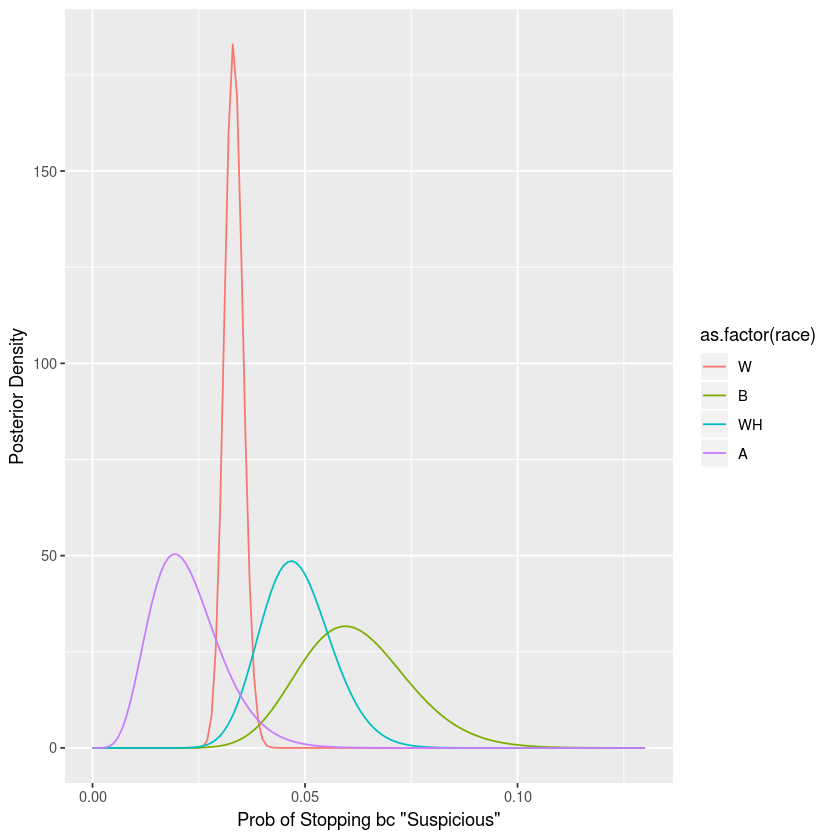

In [11]:
prob.susp.by.race = function(x,r){ data %>%
                                       filter(raceethn==r) %>%
                                       select(rpt2.suspicious) %>%
                                       as.matrix %>%
                                       unif.beta.updated(x,.) %>%
                                       return }

x = seq(0,.13,.001)
plot.df = sapply(data %>%
                 group_by(raceethn2) %>%
                 filter(n()>100) %>% as.data.frame %>%
                 select(raceethn2) %>%
                 unique %>% .[,1],
                 function(r){x %>% prob.susp.by.race(r)}) %>% as.data.frame

plot.df$x = x
plot.df = plot.df %>% melt('x') %>% set_colnames(c('x','race','post'))
p = ggplot( plot.df, aes(x=x, y=post, color=as.factor(race), group=race) ) +
    geom_line() +
    xlab('Prob of Stopping bc "Suspicious"') + ylab('Posterior Density')
p

In [12]:
dat %>% group_by(race) %>% summarize( mean(stoptime ))

race,mean(stoptime)
,1156.822
A,1237.339
B,1124.708
I,1470.028
U,1265.600
W,1278.223
